In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn

In [3]:
input_image_path = '/Users/phamminhtuan/Desktop/AIChallenge/IMG_1581_iter_0.jpg' 
output_image_path = '/Users/phamminhtuan/Desktop/AIChallenge/output2.jpg' 

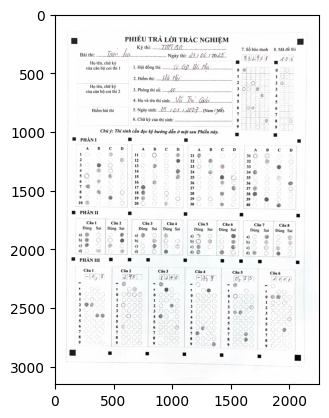

In [4]:
image = cv2.imread(input_image_path)
plt.imshow(image)

In [5]:
gray = cv2.cvtColor(image,  cv2.COLOR_BGR2GRAY)

True

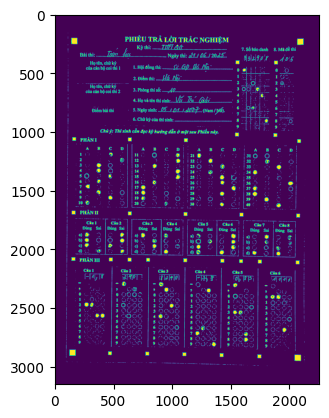

In [6]:
_, thresh = cv2.threshold(gray, 200, 255, cv2.THRESH_BINARY_INV)
plt.imshow(thresh)
cv2.imwrite('/Users/phamminhtuan/Desktop/AIChallenge/thresh.jpg', thresh)

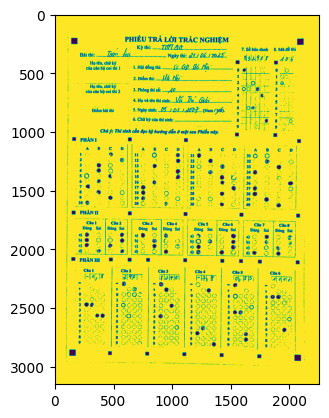

In [9]:
mask = np.uint8(thresh < 100)
plt.imshow(mask)

In [ ]:
class CircleFinding(nn.Module):
    def __init__(self, x):
        super(CircleFinding, x)

In [39]:
input_image_path = '/Users/phamminhtuan/Desktop/AIChallenge/IMG_1581_iter_0.jpg' 
output_image_path = '/Users/phamminhtuan/Desktop/AIChallenge/output2.jpg' 

In [51]:
import cv2
import numpy as np

def draw_square_around_each_circle(image_input_path, image_output_path):
    """
    Detects pencil-drawn circles in an image and draws a square around each of them.

    Args:
        image_input_path (str): The path to the input image.
        image_output_path (str): The path to save the output image.

    Returns:
        None
    """
    # Đọc ảnh
    image = cv2.imread(image_input_path)
    output = image.copy()

    # Chuyển ảnh sang grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Áp dụng medianBlur để giảm nhiễu
    
    gray[gray < 100] = 255
    # Phát hiện các hình tròn sử dụng HoughCircles
    circles = cv2.HoughCircles(gray, cv2.HOUGH_GRADIENT, dp=1, minDist=20,
                               param1=50, param2=15, minRadius=10, maxRadius=21)

    # Kiểm tra nếu có hình tròn được phát hiện
    if circles is not None:
        circles = np.uint16(np.around(circles))

        # Duyệt qua từng hình tròn và vẽ hình vuông bao quanh
        for circle in circles[0, :]:
            # Lấy tọa độ tâm và bán kính của mỗi hình tròn
            x, y, r = circle

            # Tính toán các điểm cực trị của hình tròn
            top_left = (x - r, y - r)  # Góc trên trái
            bottom_right = (x + r, y + r)  # Góc dưới phải

            # Vẽ hình vuông bao quanh hình tròn
            cv2.rectangle(output, top_left, bottom_right, (0, 255, 0), 2)

    # Lưu ảnh kết quả
    cv2.imwrite(image_output_path, output)
    print(f"Output image saved to: {image_output_path}")

# Gọi hàm để vẽ hình vuông bao quanh từng hình tròn
draw_square_around_each_circle(input_image_path, output_image_path)


Output image saved to: /Users/phamminhtuan/Desktop/AIChallenge/output2.jpg


True

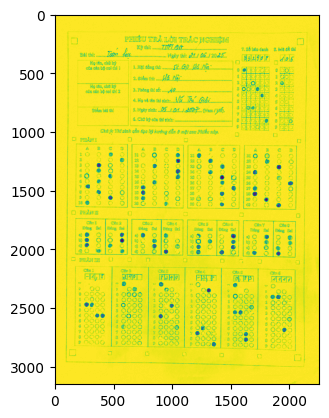

In [48]:
gray = cv2.cvtColor(image,  cv2.COLOR_BGR2GRAY)
gray[gray < 90] = 255

plt.imshow(gray)
cv2.imwrite('/Users/phamminhtuan/Desktop/AIChallenge/thresh.jpg', gray)